In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize

In [2]:
# 1. Parameters
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 1e-4
train_dir = '../../data4/train'
val_dir   = '../../data4/validation'
test_dir  = '../../data4/test'

# 2. Data Generators
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   horizontal_flip=True,
                                   vertical_flip=True)
val_datagen   = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen  = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

num_classes = train_generator.num_classes
class_labels = list(train_generator.class_indices.keys())
print("Classes:", class_labels)

Found 5999 images belonging to 4 classes.
Found 1672 images belonging to 4 classes.
Found 1672 images belonging to 4 classes.
Classes: ['1. Enfeksiyonel', '2. Ekzama', '3. Akne', '4. Malign']


In [3]:
# 3. Load and Configure ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, 
                      input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

# Freeze first (all but last 50) layers
for layer in base_model.layers[:-50]:
    layer.trainable = False
for layer in base_model.layers[-50:]:
    layer.trainable = True

# Add classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
output = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,595,908 (90.01 MB)

 Trainable params: 16,958,724 (64.69 MB)

 Non-trainable params: 6,637,184 (25.32 MB)

In [4]:
# 4. Fine-tune
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS
)


Epoch 1/10


/Users/liraj/.pyenv/versions/3.9.4/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


188/188 ━━━━━━━━━━━━━━━━━━━━ 401s 2s/step - accuracy: 0.6807 - loss: 0.7935 - val_accuracy: 0.7650 - val_loss: 0.6190
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 385s 2s/step - accuracy: 0.8705 - loss: 0.3507 - val_accuracy: 0.8134 - val_loss: 0.4962
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 406s 2s/step - accuracy: 0.9165 - loss: 0.2440 - val_accuracy: 0.8218 - val_loss: 0.5036
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 409s 2s/step - accuracy: 0.9507 - loss: 0.1624 - val_accuracy: 0.8349 - val_loss: 0.5497
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 409s 2s/step - accuracy: 0.9643 - loss: 0.1086 - val_accuracy: 0.8140 - val_loss: 0.7137
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 406s 2s/step - accuracy: 0.9692 - loss: 0.0981 - val_accuracy: 0.8391 - val_loss: 0.6176
Epoch 7/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 421s 2s/step - accuracy: 0.9742 - loss: 0.0821 - val_accuracy: 0.8254 - val_loss: 0.6368
Epoch 8/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 407s 2s/step - accuracy: 0.9792 - loss: 0.0633 - val_accuracy: 0.836

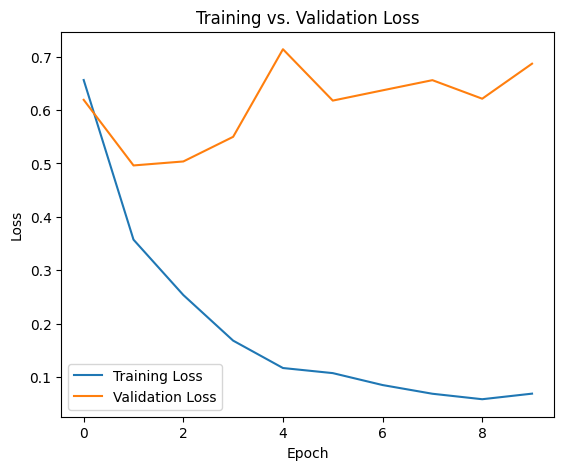

In [5]:
# 5. Plot Training vs. Validation Curves
plt.figure(figsize=(14, 5))
# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs. Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


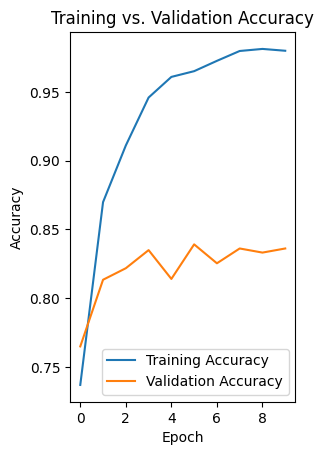

In [6]:
# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


53/53 ━━━━━━━━━━━━━━━━━━━━ 52s 977ms/step - accuracy: 0.7873 - loss: 0.8417
Test Loss: 0.6519206762313843
Test Accuracy: 0.8438995480537415
53/53 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step

Classification Report:
                 precision    recall  f1-score   support

1. Enfeksiyonel       0.79      0.73      0.76       450
      2. Ekzama       0.75      0.88      0.81       450
        3. Akne       0.92      0.90      0.91       322
      4. Malign       0.96      0.88      0.92       450

       accuracy                           0.84      1672
      macro avg       0.86      0.85      0.85      1672
   weighted avg       0.85      0.84      0.84      1672

Confusion Matrix:
 [[328 102  12   8]
 [ 41 397   6   6]
 [ 17  14 290   1]
 [ 27  19   8 396]]
Macro-average ROC AUC: 0.9623596992225578
Micro-average ROC AUC: 0.9654171841494776


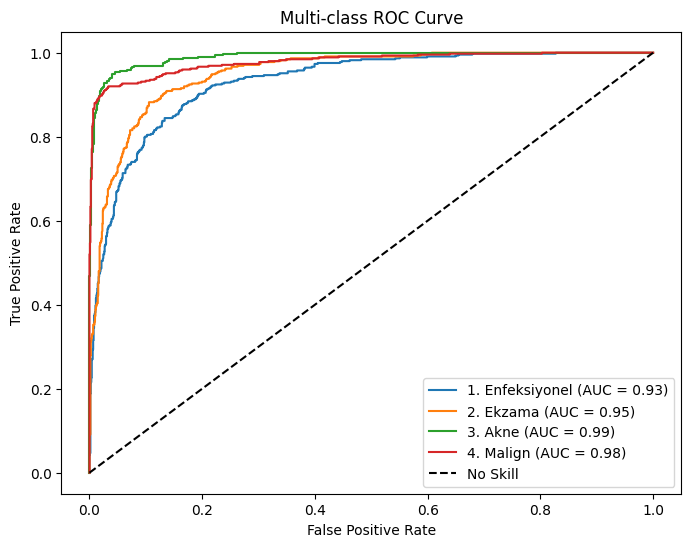

In [7]:
# 6. Evaluate on Test Set
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# 7. Classification Report & Confusion Matrix
y_pred_probs = model.predict(test_generator)
y_pred_indices = np.argmax(y_pred_probs, axis=1)
y_true_indices = test_generator.classes

print("\nClassification Report:")
print(classification_report(y_true_indices, y_pred_indices, target_names=class_labels))

cm = confusion_matrix(y_true_indices, y_pred_indices)
print("Confusion Matrix:\n", cm)

# 8. Multi-class ROC & AUC
y_true_binarized = label_binarize(y_true_indices, classes=range(num_classes))

macro_roc_auc = roc_auc_score(y_true_binarized, y_pred_probs, 
                              multi_class='ovr', average='macro')
micro_roc_auc = roc_auc_score(y_true_binarized, y_pred_probs, 
                              multi_class='ovr', average='micro')
print("Macro-average ROC AUC:", macro_roc_auc)
print("Micro-average ROC AUC:", micro_roc_auc)

fpr = {}
tpr = {}
roc_auc_classwise = {}

plt.figure(figsize=(8, 6))
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred_probs[:, i])
    roc_auc_classwise[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label='{} (AUC = {:.2f})'.format(class_labels[i], roc_auc_classwise[i]))

plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [8]:
# 6. Evaluate on Test Set
test_loss, test_accuracy = model.evaluate(val_generator)
print("Val Loss:", test_loss)
print("Val Accuracy:", test_accuracy)

53/53 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.7590 - loss: 0.9693
Val Loss: 0.6866782307624817
Val Accuracy: 0.8361244201660156


In [9]:
# 7. Classification Report & Confusion Matrix
y_pred_probs = model.predict(val_generator)
y_pred_indices = np.argmax(y_pred_probs, axis=1)
y_true_indices = val_generator.classes

print("\nClassification Report:")
print(classification_report(y_true_indices, y_pred_indices, target_names=class_labels))

cm = confusion_matrix(y_true_indices, y_pred_indices)
print("Confusion Matrix:\n", cm)

53/53 ━━━━━━━━━━━━━━━━━━━━ 52s 979ms/step

Classification Report:
                 precision    recall  f1-score   support

1. Enfeksiyonel       0.76      0.72      0.74       450
      2. Ekzama       0.75      0.87      0.80       450
        3. Akne       0.92      0.87      0.89       322
      4. Malign       0.97      0.90      0.93       450

       accuracy                           0.84      1672
      macro avg       0.85      0.84      0.84      1672
   weighted avg       0.84      0.84      0.84      1672

Confusion Matrix:
 [[323 105  14   8]
 [ 49 390   8   3]
 [ 26  15 279   2]
 [ 28  13   3 406]]
